<a href="https://colab.research.google.com/github/Hadi-Legion/ores5160-2025/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mini Health Data Warehouse: Programming & Governance for Structured Clinical Data

## 0) Setup

In [ ]:

try:
    from google.colab import drive
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, re, json, zipfile
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) Paths



In [ ]:
DATA_DIR = "/content/drive/MyDrive/Ores datasets"
SYNTHEA_CSV_ZIP = os.path.join(DATA_DIR, "/content/drive/MyDrive/Ores datasets/synthea_sample_data_csv_nov2021.zip")
SYNTHEA_FHIR_ZIP = os.path.join(DATA_DIR, "/content/drive/MyDrive/Ores datasets/synthea_sample_data_fhir_r4_sep2019.zip")
CMS_HOSPITALS_CSV_URL = "https://data.cms.gov/provider-data/api/1/datastore/query/xubh-q36u/0/download?format=csv"


WORK_DIR = "./work"
OUT_DIR = "./outputs"
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

SYNTHEA_CSV_DIR = os.path.join(WORK_DIR, "synthea_csv")
SYNTHEA_FHIR_DIR = os.path.join(WORK_DIR, "synthea_fhir_r4")

## 2) Unzip datasets

In [ ]:
def unzip_if_needed(zip_path: str, out_dir: str):
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Missing: {zip_path}. Check DATA_DIR and filenames.")
    if os.path.exists(out_dir) and len(os.listdir(out_dir)) > 0:
        print(f"Already unzipped: {out_dir}")
        return
    os.makedirs(out_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(out_dir)
    print(f"Unzipped -> {out_dir}")

unzip_if_needed(SYNTHEA_CSV_ZIP, SYNTHEA_CSV_DIR)
unzip_if_needed(SYNTHEA_FHIR_ZIP, SYNTHEA_FHIR_DIR)


Already unzipped: ./work/synthea_csv
Already unzipped: ./work/synthea_fhir_r4


## 3) Load Synthea CSV (patients + encounters)

In [ ]:
def snake(s: str) -> str:
    s = re.sub(r'[^0-9a-zA-Z]+', '_', s).strip('_').lower()
    return s

def find_file(root: str, filename: str) -> str:
    for dirpath, _, files in os.walk(root):
        if filename in files:
            return os.path.join(dirpath, filename)
    raise FileNotFoundError(f"Could not find {filename} under {root}")

patients_path = find_file(SYNTHEA_CSV_DIR, "patients.csv")
encounters_path = find_file(SYNTHEA_CSV_DIR, "encounters.csv")

patients = pd.read_csv(patients_path)
encounters = pd.read_csv(encounters_path)

patients.columns = [snake(c) for c in patients.columns]
encounters.columns = [snake(c) for c in encounters.columns]

print("patients:", patients.shape)
print("encounters:", encounters.shape)
patients.head()


patients: (1163, 25)
encounters: (61459, 15)


,id,birthdate,deathdate,ssn,drivers,passport,prefix,first,last,suffix,maiden,marital,race,ethnicity,gender,birthplace,address,city,state,county,zip,lat,lon,healthcare_expenses,healthcare_coverage
0,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,2019-02-17,NaN,999-65-3251,NaN,NaN,NaN,Damon455,Langosh790,NaN,NaN,NaN,white,nonhispanic,M,Middleborough Massachusetts US,620 Lynch Tunnel Apt 0,Springfield,Massachusetts,Hampden County,1104.0,42.080389,-72.480431,9039.1645,7964.1255
1,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,2005-07-04,NaN,999-49-3323,S99941126,NaN,NaN,Thi53,Wunsch504,NaN,NaN,NaN,white,nonhispanic,F,Danvers Massachusetts US,972 Tillman Branch Suite 48,Bellingham,Massachusetts,Norfolk County,NaN,42.035213,-71.482519,402723.4150,14064.1350
2,339144f8-50e1-633e-a013-f361391c4cff,1998-05-11,NaN,999-10-8743,S99996708,X75063318X,Mr.,Chi716,Greenfelder433,NaN,NaN,NaN,white,nonhispanic,M,Athens Athens Prefecture GR,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375
3,d488232e-bf14-4bed-08c0-a82f34b6a197,2003-01-28,NaN,999-56-6057,S99929424,NaN,Ms.,Phillis443,Walter473,NaN,NaN,NaN,white,nonhispanic,F,Boston Massachusetts US,677 Ritchie Terrace,Hingham,Massachusetts,Plymouth County,2043.0,42.200491,-70.916076,582557.8030,104782.2070
4,217f95a3-4e10-bd5d-fb67-0cfb5e8ba075,1993-12-23,NaN,999-91-4320,S99991143,X44132498X,Mr.,Jerrold404,Herzog843,NaN,NaN,M,black,nonhispanic,M,Boston Massachusetts US,276 Bernier Branch,Revere,Massachusetts,Suffolk County,NaN,42.381875,-70.999286,475826.8550,18067.0950


## 4) Data quality checks

In [ ]:
req_pat = ["id", "birthdate", "gender"]
req_enc = ["id", "patient", "start", "stop"]

missing_pat = [c for c in req_pat if c not in patients.columns]
missing_enc = [c for c in req_enc if c not in encounters.columns]
if missing_pat or missing_enc:
    raise ValueError(f"Missing required columns. patients missing={missing_pat}, encounters missing={missing_enc}")

patients["birthdate"] = pd.to_datetime(patients["birthdate"], errors="coerce", utc=True).dt.tz_convert(None)
encounters["start"] = pd.to_datetime(encounters["start"], errors="coerce", utc=True).dt.tz_convert(None)
encounters["stop"]  = pd.to_datetime(encounters["stop"],  errors="coerce", utc=True).dt.tz_convert(None)
encounters["los_days"] = (encounters["stop"] - encounters["start"]).dt.total_seconds() / (60*60*24)

dq = {
    "patients_missing_birthdate": int(patients['birthdate'].isna().sum()),
    "encounters_missing_start": int(encounters['start'].isna().sum()),
    "encounters_missing_stop": int(encounters['stop'].isna().sum()),
    "patients_duplicate_id_rows": int(patients.duplicated(subset=['id']).sum()),
    "encounters_duplicate_id_rows": int(encounters.duplicated(subset=['id']).sum()),
    "encounters_negative_los_rows": int((encounters['los_days'] < 0).sum()),
}
dq


{'patients_missing_birthdate': 0,
 'encounters_missing_start': 0,
 'encounters_missing_stop': 0,
 'patients_duplicate_id_rows': 0,
 'encounters_duplicate_id_rows': 0,
 'encounters_negative_los_rows': 0}

## 5) Visuals

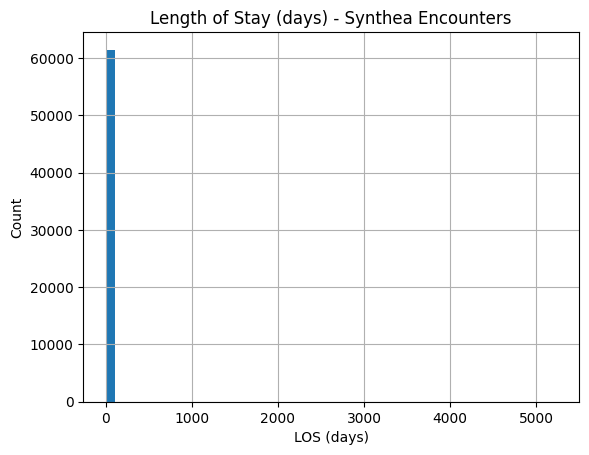

In [ ]:
enc = encounters.merge(
    patients[['id','birthdate','gender']].rename(columns={'id':'patient_id'}),
    left_on='patient', right_on='patient_id', how='left'
)

enc['age_years'] = (enc['start'] - enc['birthdate']).dt.days / 365.25

# 1) LOS histogram
plt.figure()
enc['los_days'].dropna().clip(lower=0).hist(bins=50)
plt.title("Length of Stay (days) - Synthea Encounters")
plt.xlabel("LOS (days)")
plt.ylabel("Count")
los_fig = os.path.join(OUT_DIR, "los_hist.png")
plt.savefig(los_fig, bbox_inches="tight", dpi=200)
plt.show()
plt.close()



<Figure size 640x480 with 0 Axes>

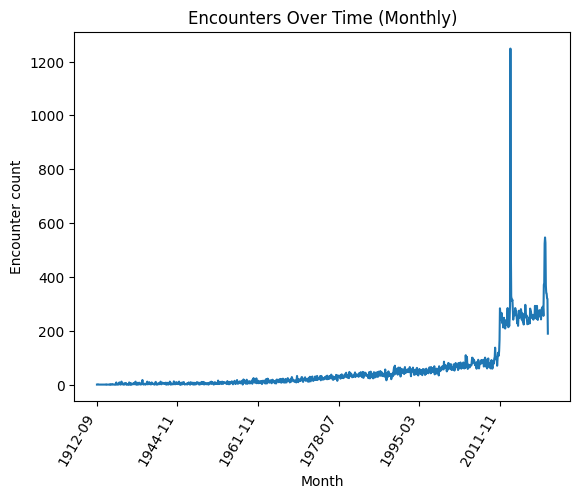

In [ ]:
# 2) Encounters per month
plt.figure()
monthly = (
    enc.dropna(subset=['start'])
       .assign(month=lambda d: d['start'].dt.to_period('M').astype(str))
       .groupby('month')['id'].count()
       .reset_index(name='encounters')
)
monthly.plot(x='month', y='encounters', kind='line', legend=False)
plt.title("Encounters Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Encounter count")
plt.xticks(rotation=60, ha="right")
trend_fig = os.path.join(OUT_DIR, "encounters_trend.png")
plt.savefig(trend_fig, bbox_inches="tight", dpi=200)
plt.show()
plt.close()

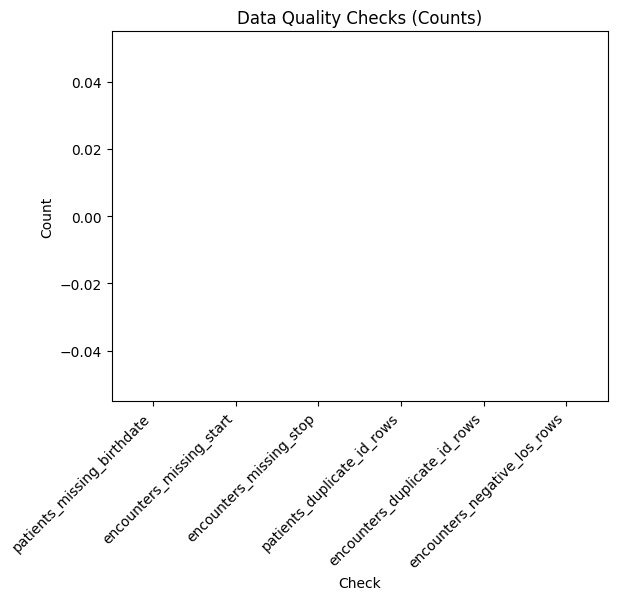

('./outputs/los_hist.png',
 './outputs/encounters_trend.png',
 './outputs/dq_checks.png')

In [ ]:
# 3) Data quality bar chart
plt.figure()
pd.Series(dq).sort_values(ascending=False).plot(kind="bar")
plt.title("Data Quality Checks (Counts)")
plt.xlabel("Check")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
dq_fig = os.path.join(OUT_DIR, "dq_checks.png")
plt.savefig(dq_fig, bbox_inches="tight", dpi=200)
plt.show()
plt.close()

(los_fig, trend_fig, dq_fig)

## 6) Parse FHIR R4 bundles (JSON)


In [ ]:
def iter_json_files(root: str, max_files: int | None = 300):
    n = 0
    for dirpath, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith(".json"):
                yield os.path.join(dirpath, f)
                n += 1
                if max_files is not None and n >= max_files:
                    return

def bundle_counts(bundle: dict):
    entries = bundle.get("entry", []) or []
    patient_id = None
    enc = 0
    cond = 0
    for e in entries:
        res = (e or {}).get("resource", {}) or {}
        rtype = res.get("resourceType")
        if rtype == "Patient" and patient_id is None:
            patient_id = res.get("id")
        elif rtype == "Encounter":
            enc += 1
        elif rtype == "Condition":
            cond += 1
    return patient_id, enc, cond

rows = []
for fp in iter_json_files(SYNTHEA_FHIR_DIR, max_files=300):
    with open(fp, "r", encoding="utf-8") as f:
        try:
            bundle = json.load(f)
        except json.JSONDecodeError:
            continue
    pid, enc_cnt, cond_cnt = bundle_counts(bundle)
    if pid:
        rows.append({"patient_id_fhir": pid, "fhir_encounters": enc_cnt, "fhir_conditions": cond_cnt})

fhir_summary = pd.DataFrame(rows).drop_duplicates(subset=["patient_id_fhir"])
print("FHIR patient bundles parsed:", fhir_summary.shape)
fhir_summary.head()


FHIR patient bundles parsed: (300, 3)


,patient_id_fhir,fhir_encounters,fhir_conditions
0,8421e46f-8802-46a2-8b21-9fbe297a4cab,8,5
1,cf8014cd-71cb-4a58-9ead-505dad58b5db,83,15
2,6fb7de48-13eb-4c5f-83da-61b27d4bbdf3,14,6
3,80062d96-501f-46ff-98f0-a6e24edb56a1,10,5
4,6ddbf8b1-3d22-4ca8-b23a-5e55efc4c67d,86,11


## 7) CMS Hospitals

In [ ]:
cms = pd.read_csv(CMS_HOSPITALS_CSV_URL)
cms.columns = [snake(c) for c in cms.columns]
print("CMS hospitals:", cms.shape)
cms.head()


CMS hospitals: (5421, 38)


,facility_id,facility_name,address,city_town,state,zip_code,county_parish,telephone_number,hospital_type,hospital_ownership,emergency_services,meets_criteria_for_birthing_friendly_designation,hospital_overall_rating,hospital_overall_rating_footnote,mort_group_measure_count,count_of_facility_mort_measures,count_of_mort_measures_better,count_of_mort_measures_no_different,count_of_mort_measures_worse,mort_group_footnote,safety_group_measure_count,count_of_facility_safety_measures,count_of_safety_measures_better,count_of_safety_measures_no_different,count_of_safety_measures_worse,safety_group_footnote,readm_group_measure_count,count_of_facility_readm_measures,count_of_readm_measures_better,count_of_readm_measures_no_different,count_of_readm_measures_worse,readm_group_footnote,pt_exp_group_measure_count,count_of_facility_pt_exp_measures,pt_exp_group_footnote,te_group_measure_count,count_of_facility_te_measures,te_group_footnote
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,4,NaN,7,7,0,7,0,NaN,8,7,3,4,0,NaN,11,11,0,11,0,NaN,8,8,NaN,12,11,NaN
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,NaN,7,6,0,5,1,NaN,8,7,0,7,0,NaN,11,9,0,8,1,NaN,8,8,NaN,12,12,NaN
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 768-8400,Acute Care Hospitals,Proprietary,Yes,Y,2,NaN,7,7,0,5,2,NaN,8,8,3,5,0,NaN,11,9,0,8,1,NaN,8,8,NaN,12,10,NaN
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,Yes,NaN,1,NaN,7,3,0,2,1,NaN,8,3,0,3,0,NaN,11,7,0,7,0,NaN,8,8,NaN,12,7,NaN
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,Yes,NaN,Not Available,16,7,1,0,1,0,NaN,8,Not Available,Not Available,Not Available,Not Available,5.0,11,2,0,2,0,NaN,8,Not Available,5.0,12,6,NaN


In [ ]:
hospitals_by_state = cms.groupby("state").size().reset_index(name="hospital_count")                           .sort_values("hospital_count", ascending=False)

plt.figure()
hospitals_by_state.head(20).plot(x="state", y="hospital_count", kind="bar", legend=False)
plt.title("Top 20 States by # of Medicare-Registered Hospitals (CMS)")
plt.xlabel("State")
plt.ylabel("Hospitals")
plt.xticks(rotation=45, ha="right")
cms_fig = os.path.join(OUT_DIR, "cms_hospitals_by_state.png")
plt.savefig(cms_fig, bbox_inches="tight", dpi=200)
plt.close()

cms_fig


'./outputs/cms_hospitals_by_state.png'

<Figure size 640x480 with 0 Axes>

## 8) HTML ingestion

In [ ]:
cms_html_path = os.path.join(WORK_DIR, "cms_hospitals_sample.html")
cms.head(200).to_html(cms_html_path, index=False)

tables = pd.read_html(cms_html_path)
cms_from_html = tables[0]
print("Read HTML table:", cms_from_html.shape)
cms_from_html.head()


Read HTML table: (200, 38)


,facility_id,facility_name,address,city_town,state,zip_code,county_parish,telephone_number,hospital_type,hospital_ownership,emergency_services,meets_criteria_for_birthing_friendly_designation,hospital_overall_rating,hospital_overall_rating_footnote,mort_group_measure_count,count_of_facility_mort_measures,count_of_mort_measures_better,count_of_mort_measures_no_different,count_of_mort_measures_worse,mort_group_footnote,safety_group_measure_count,count_of_facility_safety_measures,count_of_safety_measures_better,count_of_safety_measures_no_different,count_of_safety_measures_worse,safety_group_footnote,readm_group_measure_count,count_of_facility_readm_measures,count_of_readm_measures_better,count_of_readm_measures_no_different,count_of_readm_measures_worse,readm_group_footnote,pt_exp_group_measure_count,count_of_facility_pt_exp_measures,pt_exp_group_footnote,te_group_measure_count,count_of_facility_te_measures,te_group_footnote
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,4,NaN,7,7,0,7,0,NaN,8,7,3,4,0,NaN,11,11,0,11,0,NaN,8,8,NaN,12,11,NaN
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,NaN,7,6,0,5,1,NaN,8,7,0,7,0,NaN,11,9,0,8,1,NaN,8,8,NaN,12,12,NaN
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 768-8400,Acute Care Hospitals,Proprietary,Yes,Y,2,NaN,7,7,0,5,2,NaN,8,8,3,5,0,NaN,11,9,0,8,1,NaN,8,8,NaN,12,10,NaN
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,Yes,NaN,1,NaN,7,3,0,2,1,NaN,8,3,0,3,0,NaN,11,7,0,7,0,NaN,8,8,NaN,12,7,NaN
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,Yes,NaN,Not Available,16.0,7,1,0,1,0,NaN,8,Not Available,Not Available,Not Available,Not Available,5.0,11,2,0,2,0,NaN,8,Not Available,5.0,12,6,NaN
